Project: Predicting Twitter Sentiment Analysis on Google and Apple Products using Natural Language Processing

Student: Jennifer Casias

Instructor: Joseph Mata

Full-time / Phase 4

# Business Understanding

**Problem** Build an NLP model that can rate the sentiment of a Tweet based on its content.

**Stakeholder**
A Market Research Firm: A market research firm might be hired by a third-party company to conduct a sentiment analysis on Twitter data related to Google and Apple products. The third-party company might be interested in understanding which brand is perceived more positively in the market, which product features are most important to customers, and how customers feel about the brand's technology. The third-party company would then present the results of the analysis to the market research firm. 

# Data
The dataset comes from CrowdFlower via [data.world](https://data.world/crowdflower/brands-and-product-emotions). 

**Supervised:** Human raters rated the sentiment in over 9,000 tweets.

In [465]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.dummy import DummyClassifier
from collections import Counter
import networkx as nx
from wordcloud import WordCloud 

# Import specific functions from sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Import specific functions from matplotlib
from matplotlib.ticker import FixedLocator


# Import data
df = pd.read_csv('data/google:apple_tweets.csv', encoding='ISO-8859-1')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [466]:
print(df.iloc[9088]['tweet_text'])

Ipad everywhere. #SXSW {link}


In [467]:
df['tweet_text'][0].replace

<function str.replace(old, new, count=-1, /)>

In [468]:
# Remove usernames, hashtags, and hyperlinks
# Define a function to remove Twitter usernames
def remove_usernames(text):
    # replace usernames with an empty string
    return re.sub(r'@\w+', '', text)

# Define a function to remove hashtags
def remove_hashtags(text):
    # replace hashtags with an empty string
    return re.sub(r'#\w+', '', text)

# Define a function to remove hyperlinks
def remove_hyperlinks(text):
    # replace hyperlinks with an empty string
    return re.sub(r'http\S+', '', text)


# Apply the functions to the 'tweet_text' column of your original DataFrame
df['tweet_text'] = df['tweet_text'].apply(lambda x: remove_usernames(x) if isinstance(x, str) else x)
df['tweet_text'] = df['tweet_text'].apply(lambda x: remove_hashtags(x) if isinstance(x, str) else x)
df['tweet_text'] = df['tweet_text'].apply(lambda x: remove_hyperlinks(x) if isinstance(x, str) else x)
df['tweet_text'] = df['tweet_text'].apply(lambda x: str(x).replace('{link}',''))

# Apply the functions to the entire DataFrame
df = df.applymap(lambda x: remove_usernames(x) if isinstance(x, str) else x)
df = df.applymap(lambda x: remove_hashtags(x) if isinstance(x, str) else x)
df = df.applymap(lambda x: remove_hyperlinks(x) if isinstance(x, str) else x)

df.drop(9092, axis =0, inplace = True)

# Sanity check!
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,. I have a 3G iPhone. After 3 hrs tweeting at ...,iPhone,Negative emotion
1,Know about ? Awesome iPad/iPhone app that yo...,iPad or iPhone App,Positive emotion
2,Can not wait for 2 also. They should sale th...,iPad,Positive emotion
3,I hope this year's festival isn't as crashy a...,iPad or iPhone App,Negative emotion
4,"great stuff on Fri : Marissa Mayer (Google), ...",Google,Positive emotion
...,...,...,...
9087,"Yup, but I don't have a third app yet. I'm on...",NaN,No emotion toward brand or product
9088,Ipad everywhere.,iPad,Positive emotion
9089,"Wave, buzz... RT We interrupt your regularly ...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product


In [469]:
# Rename columns
df = df.rename(columns={
    'tweet_text': 'tweet',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'
})

In [470]:
# What's in product
product_list = df['product'].unique().tolist()
print(product_list)

['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android', 'Apple', 'Android App', 'Other Google product or service', 'Other Apple product or service']


In [471]:
# What's in sentiment
product_list = df['sentiment'].unique().tolist()
print(product_list)

['Negative emotion', 'Positive emotion', 'No emotion toward brand or product', "I can't tell"]


In [472]:
# Create a boolean DataFrame indicating which values are NaN
nan_df = df.isna()

# Determine which columns have NaN values
cols_with_nan = nan_df.any()
print(cols_with_nan)

tweet        False
product       True
sentiment    False
dtype: bool


In [473]:
# Drop NaNs in tweet
print(df['tweet'].isna().sum())

0


**What does the imbalance look like?**

/var/folders/lj/7nxfhmdd09gchghpg0g2z8vc0000gn/T/ipykernel_1472/3127898009.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sentiment_counts.index, rotation=90)


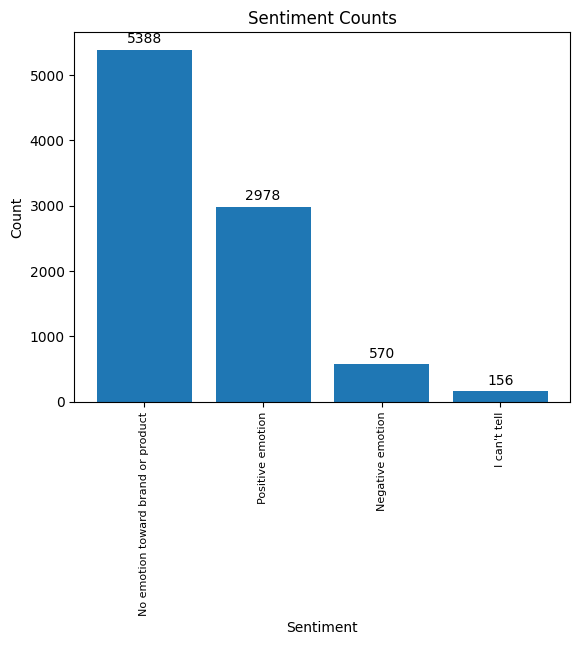

In [474]:
sentiment_counts = df['sentiment'].value_counts()

# create a bar chart
fig, ax = plt.subplots()
bars = ax.bar(sentiment_counts.index, sentiment_counts.values)

# add labels to the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# set x-axis tick labels to be vertical
ax.set_xticklabels(sentiment_counts.index, rotation=90)

# set chart title and axis labels
ax.set_title('Sentiment Counts')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

# set font size for x-axis tick labels
plt.xticks(fontsize=8)

# display the chart
plt.show()

In [475]:
# Replace NaN values in 'product' column with 'no answer'
df['product'] = df['product'].fillna('no answer')

# Drop rows with NaN values in 'tweet' column
df = df.dropna(subset=['tweet'])

In [476]:
# Retrieve unique values in the 'sentiment' column
unique_sentiments = df['sentiment'].unique()
unique_sentiments

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [477]:
# What's the variation of sentiment
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64


In [478]:
# Replace remaining values in the 'sentiment' column
df['sentiment'] = df['sentiment'].replace({
    'Negative emotion': 'negative',
    'Positive emotion': 'positive',
    "I can't tell": 'neutral',
    'No emotion toward brand or product': 'neutral'
})

# Print first few rows of updated dataframe
print(df.head())

                                               tweet             product  \
0  . I have a 3G iPhone. After 3 hrs tweeting at ...              iPhone   
1   Know about  ? Awesome iPad/iPhone app that yo...  iPad or iPhone App   
2   Can not wait for  2 also. They should sale th...                iPad   
3   I hope this year's festival isn't as crashy a...  iPad or iPhone App   
4   great stuff on Fri : Marissa Mayer (Google), ...              Google   

  sentiment  
0  negative  
1  positive  
2  positive  
3  negative  
4  positive  


In [479]:
# Setting sentiment column to numerical values
# Define the mapping of sentiment categories to numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}

# Map the sentiment column to numerical values using the mapping dictionary
df['sentiment'] = df['sentiment'].map(sentiment_mapping)
df

,tweet,product,sentiment
0,. I have a 3G iPhone. After 3 hrs tweeting at ...,iPhone,-1
1,Know about ? Awesome iPad/iPhone app that yo...,iPad or iPhone App,1
2,Can not wait for 2 also. They should sale th...,iPad,1
3,I hope this year's festival isn't as crashy a...,iPad or iPhone App,-1
4,"great stuff on Fri : Marissa Mayer (Google), ...",Google,1
...,...,...,...
9087,"Yup, but I don't have a third app yet. I'm on...",no answer,0
9088,Ipad everywhere.,iPad,1
9089,"Wave, buzz... RT We interrupt your regularly ...",no answer,0
9090,"Google's Zeiger, a physician never reported po...",no answer,0


In [480]:
# New variation
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

 0    5544
 1    2978
-1     570
Name: sentiment, dtype: int64


In [481]:
# Make a copy of df
df2 = df.copy()

# NLP Preprocessing

In [482]:
# Remove punctuation marks using string module
df2['tweet'] = df2['tweet'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if type(x)==str else x)

# Remove special characters using regex
df2['tweet'] = df2['tweet'].apply(lambda x: re.sub(r'\W+', ' ', x) if type(x)==str else x)

# Convert 'tweet' column to lowercase
df2['tweet'] = df2['tweet'].str.lower()

# Tokenize the text into individual words
df2['tokens'] = df2['tweet'].apply(lambda x: nltk.word_tokenize(x) if type(x)==str else x)

# Remove stopwords from the tokens
stop_words = set(stopwords.words('english'))
df2['tokens'] = df2['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words] if type(x)==list else x)

# Perform lemmatization on the tokens
lemmatizer = WordNetLemmatizer()
df2['lemmatized'] = df2['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x] if type(x)==list else x)

# Print first few rows of cleaned, tokenized and lemmatized dataframe
df2

,tweet,product,sentiment,tokens,lemmatized
0,i have a 3g iphone after 3 hrs tweeting at it...,iPhone,-1,"[3g, iphone, 3, hrs, tweeting, dead, need, upg...","[3g, iphone, 3, hr, tweeting, dead, need, upgr..."
1,know about awesome ipadiphone app that youll ...,iPad or iPhone App,1,"[know, awesome, ipadiphone, app, youll, likely...","[know, awesome, ipadiphone, app, youll, likely..."
2,can not wait for 2 also they should sale them...,iPad,1,"[wait, 2, also, sale]","[wait, 2, also, sale]"
3,i hope this years festival isnt as crashy as ...,iPad or iPhone App,-1,"[hope, years, festival, isnt, crashy, years, i...","[hope, year, festival, isnt, crashy, year, iph..."
4,great stuff on fri marissa mayer google tim o...,Google,1,"[great, stuff, fri, marissa, mayer, google, ti...","[great, stuff, fri, marissa, mayer, google, ti..."
...,...,...,...,...,...
9087,yup but i dont have a third app yet im on and...,no answer,0,"[yup, dont, third, app, yet, im, android, sugg...","[yup, dont, third, app, yet, im, android, sugg..."
9088,ipad everywhere,iPad,1,"[ipad, everywhere]","[ipad, everywhere]"
9089,wave buzz rt we interrupt your regularly sched...,no answer,0,"[wave, buzz, rt, interrupt, regularly, schedul...","[wave, buzz, rt, interrupt, regularly, schedul..."
9090,googles zeiger a physician never reported pote...,no answer,0,"[googles, zeiger, physician, never, reported, ...","[google, zeiger, physician, never, reported, p..."


In [483]:
# Combine all tweets into a single string
text = " ".join(tweet for tweet in df2['tweet'])

# Tokenize the text into individual words
words = nltk.tokenize.word_tokenize(text)

# Calculate the frequency distribution of words
freq_dist = FreqDist(words)

# Define a minimum frequency threshold
min_freq = 5

# Remove rare words from the text
clean_text = " ".join(word for word in words if freq_dist[word] > min_freq)

In [484]:
# Make a copy
df3 = df2.copy()

## EDA

**Which products have the highest overall sentiment?**

In [492]:
# Convert sentiment to numeric
df3['sentiment'] = pd.to_numeric(df3['sentiment'], errors='coerce')

# Group by product and calculate the average sentiment score
sentiment_by_product = df3.groupby('product')['sentiment'].mean()

# Sort the results in descending order to identify the products with the highest sentiment
sentiment_by_product = sentiment_by_product.sort_values(ascending=False)
print(sentiment_by_product)

product
Other Apple product or service     0.857143
Android App                        0.790123
Android                            0.782051
iPad or iPhone App                 0.710638
iPad                               0.706131
Apple                              0.677761
Google                             0.646512
Other Google product or service    0.645051
iPhone                             0.272727
no answer                          0.043958
Name: sentiment, dtype: float64


**Which Product had the highest overall sentiment?**

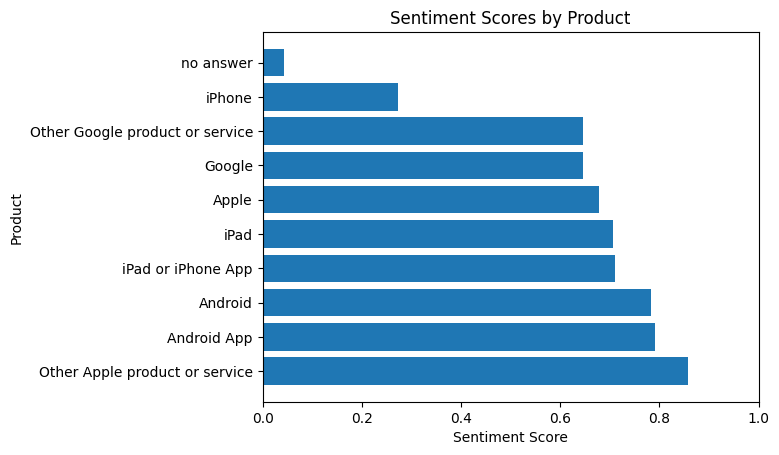

In [493]:
# Create a horizontal bar chart
plt.barh(sentiment_by_product.index, sentiment_by_product.values)

# Set the x-axis limit
plt.xlim(0, 1)

# Add a title and labels for the x-axis and y-axis
plt.title('Sentiment Scores by Product')
plt.xlabel('Sentiment Score')
plt.ylabel('Product')

# Display the chart
plt.show()

**How does the sentiment of tweets compare among the different products?**

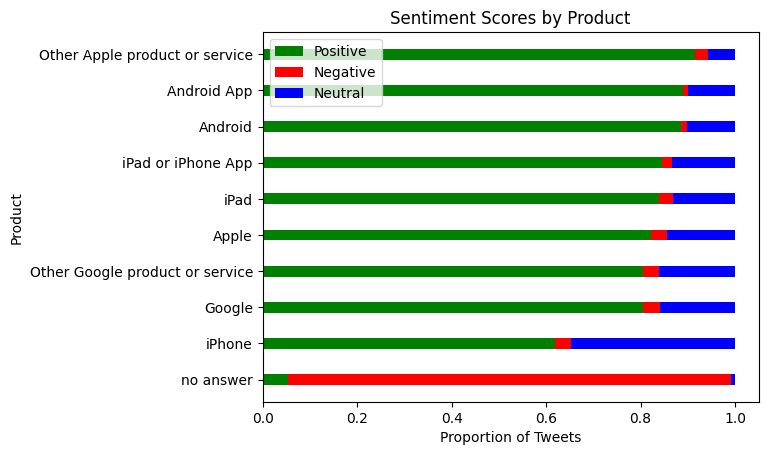

In [494]:
# Calculate the number of positive, negative, and neutral sentiment scores for each product
sentiment_counts = df3.groupby(['product', 'sentiment']).size().unstack(fill_value=0)

# Normalize the sentiment counts to create proportions
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Sort the products by their positivity score
sentiment_by_product = sentiment_proportions[1].sort_values(ascending=True)

# Create a stacked bar chart
fig, ax = plt.subplots()
ind = np.arange(len(sentiment_proportions.index))
width = 0.3

p1 = ax.barh(ind, sentiment_proportions[1][sentiment_by_product.index], width, color='g')
p2 = ax.barh(ind, sentiment_proportions[0][sentiment_by_product.index], width, left=sentiment_proportions[1][sentiment_by_product.index], color='r')
p3 = ax.barh(ind, sentiment_proportions[-1][sentiment_by_product.index], width, left=sentiment_proportions[1][sentiment_by_product.index]+sentiment_proportions[0][sentiment_by_product.index], color='b')

# Add a legend for the positive, negative, and neutral sentiment bars
ax.legend((p1[0], p2[0], p3[0]), ('Positive', 'Negative', 'Neutral'), loc='best')

# Add a title and labels for the x-axis and y-axis
ax.set_title('Sentiment Scores by Product')
ax.set_yticks(ind)
ax.set_yticklabels(sentiment_by_product.index)
ax.set_xlabel('Proportion of Tweets')
ax.set_ylabel('Product')

# Display the chart
plt.show()

**What are the negative tweets among the products?**

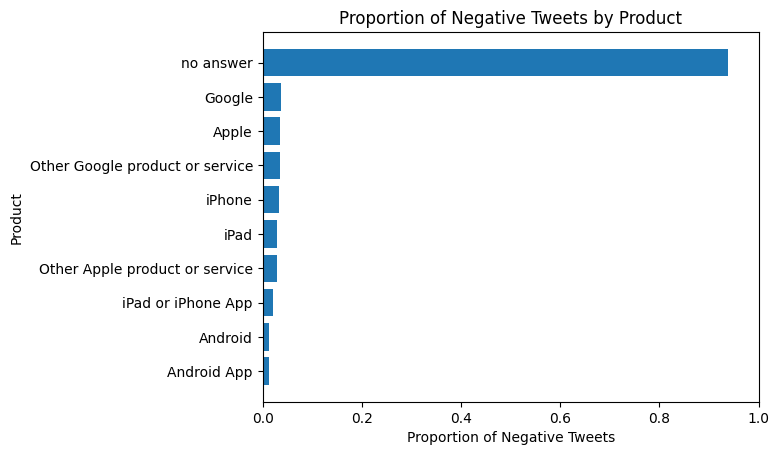

In [495]:
# Calculate the number of negative sentiment scores for each product
negative_counts = df3[df3['sentiment'] == 0].groupby('product').size()

# Calculate the proportion of negative sentiment tweets for each product
negative_proportions = negative_counts / df3.groupby('product').size()

# Sort the products by their proportion of negative sentiment tweets
negative_proportions = negative_proportions.sort_values()

# Create a horizontal bar chart
fig, ax = plt.subplots()
ax.barh(negative_proportions.index, negative_proportions.values)

# Set the x-axis limit
plt.xlim(0, 1)

# Add a title and labels for the x-axis and y-axis
plt.title('Proportion of Negative Tweets by Product')
plt.xlabel('Proportion of Negative Tweets')
plt.ylabel('Product')

# Display the chart
plt.show()

**Which products were tweeted about the most?**

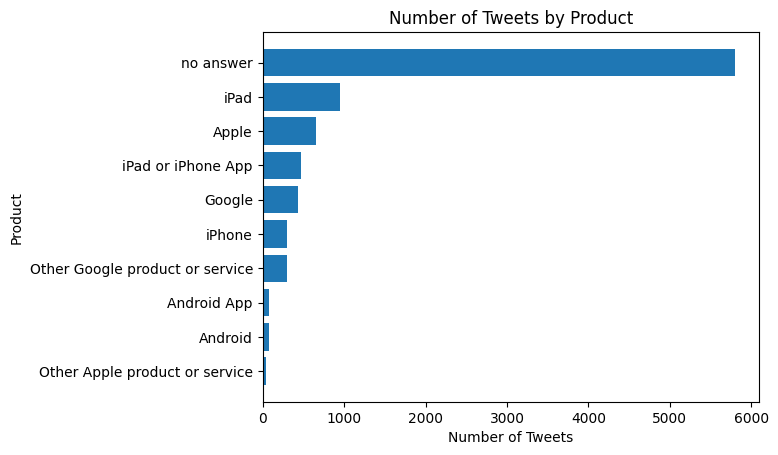

In [496]:
# Count the number of tweets for each product
tweet_counts = df3.groupby('product').size()

# Sort the products by the number of tweets
tweet_counts = tweet_counts.sort_values()

# Create a horizontal bar chart
fig, ax = plt.subplots()
ax.barh(tweet_counts.index, tweet_counts.values)

# Add a title and labels for the x-axis and y-axis
plt.title('Number of Tweets by Product')
plt.xlabel('Number of Tweets')
plt.ylabel('Product')

# Display the chart
plt.show()

/var/folders/lj/7nxfhmdd09gchghpg0g2z8vc0000gn/T/ipykernel_1472/390407518.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Negative (-1)', 'Neutral (0)', 'Positive (1)'])


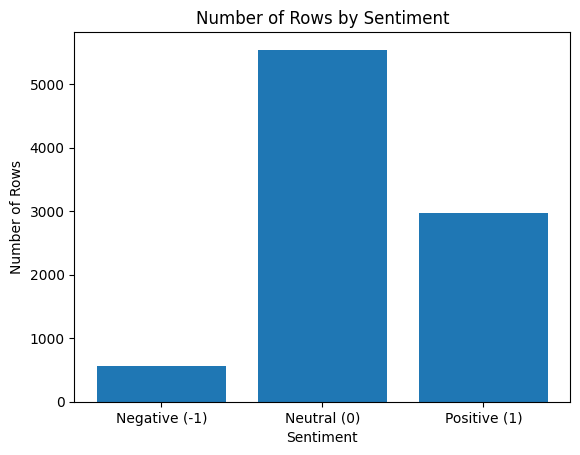

In [497]:
# Count the number of rows for each sentiment
sentiment_counts = df3.groupby('sentiment').size()

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(sentiment_counts.index, sentiment_counts.values)

# Add labels for the sentiment values
ax.set_xticklabels(['Negative (-1)', 'Neutral (0)', 'Positive (1)'])

# Set the tick locations for the x-axis
ax.xaxis.set_major_locator(FixedLocator([-1, 0, 1]))

# Add a title and labels for the x-axis and y-axis
plt.title('Number of Rows by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Rows')

# Display the chart
plt.show()

# Modeling

**Baseline Model**

In [498]:
# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

# Split data into training and test sets
X = df3['tweet']
y = df3['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict the class labels for the test data
y_pred = pipeline.predict(X_test)

# Evaluate the accuracy of the model on the test set
accuracy = pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)
train_accuracy = pipeline.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)

/opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.6838922484881803
Train Accuracy: 0.911728310188368


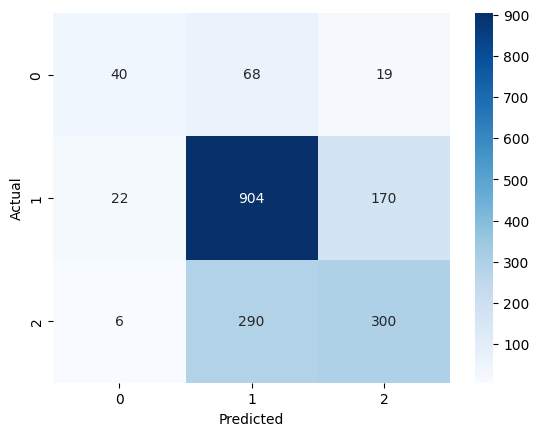

              precision    recall  f1-score      support
-1             0.588235  0.314961  0.410256   127.000000
0              0.716323  0.824818  0.766751  1096.000000
1              0.613497  0.503356  0.552995   596.000000
accuracy       0.683892  0.683892  0.683892     0.683892
macro avg      0.639352  0.547711  0.576668  1819.000000
weighted avg   0.673689  0.683892  0.671824  1819.000000


In [499]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract the individual scores for each class and store them in a DataFrame
scores_df = pd.DataFrame(report).transpose()

# Print the report
print(scores_df)

**First iteration**

In [500]:
# define X and y
X = df3['tweet'].values
y = df3['sentiment'].values

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the undersampling strategy to the training data
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train.reshape(-1, 1), y_train)

# define the pipeline steps
pipeline = ImbPipeline([
    ('vectorizer', CountVectorizer()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

# fit the pipeline on the resampled training data
pipeline.fit(X_train_resampled.squeeze(), y_train_resampled)

# make predictions on the test data
y_pred = pipeline.predict(X_test)

# evaluate the accuracy of the model
accuracy = pipeline.score(X_test, y_test)
print("Test Accuracy:", accuracy)
train_accuracy = pipeline.score(X_train_resampled.squeeze(), y_train_resampled)
print("Train Accuracy:", train_accuracy)

Test Accuracy: 0.5063221550302364
Train Accuracy: 0.9623623011015912


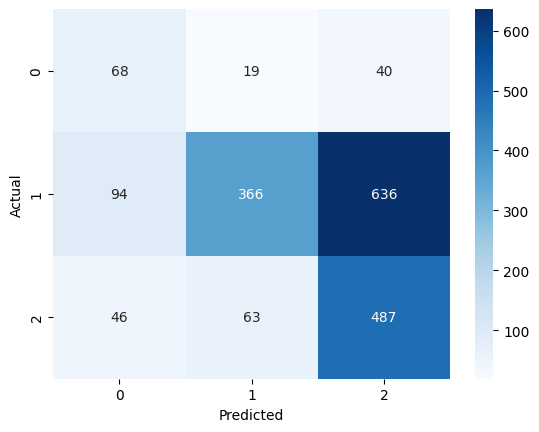

,precision,recall,f1-score,support
-1,0.326923,0.535433,0.405970,127.000000
0,0.816964,0.333942,0.474093,1096.000000
1,0.418745,0.817114,0.553724,596.000000
accuracy,0.506322,0.506322,0.506322,0.506322
macro avg,0.520877,0.562163,0.477929,1819.000000
weighted avg,0.652273,0.506322,0.495428,1819.000000


In [501]:
# generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# extract the individual scores for each class and store them in a DataFrame
scores_df = pd.DataFrame(report).transpose()

# print the report
scores_df

**Second iteration**

In [502]:
# Define X and y
X = df3['tweet'].values
y = df3['sentiment'].values

# Define the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='auto')

# Reshape the input data for oversampling
X = X.reshape(-1, 1)

# Apply oversampling to the training data
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Reshape the input data back to its original shape
X_resampled = X_resampled.reshape(-1)

# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_resampled)
X_seq = tokenizer.texts_to_sequences(X_resampled)
X_pad = pad_sequences(X_seq, maxlen=100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_resampled, test_size=0.2, random_state=42)

# Define the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=100))
model.add(Conv1D(64, 9, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(32, 9, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert y_train and y_test to categorical labels
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Compute the training accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy:', train_acc)

# Compute the testing accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy:', test_acc)

Epoch 1/10
416/416 [==============================] - 44s 104ms/step - loss: 0.9145 - accuracy: 0.5200 - val_loss: 0.7788 - val_accuracy: 0.6634
Epoch 2/10
416/416 [==============================] - 43s 103ms/step - loss: 0.5441 - accuracy: 0.7549 - val_loss: 0.5800 - val_accuracy: 0.7884
Epoch 3/10
416/416 [==============================] - 44s 105ms/step - loss: 0.4000 - accuracy: 0.8392 - val_loss: 0.5087 - val_accuracy: 0.8100
Epoch 4/10
416/416 [==============================] - 43s 104ms/step - loss: 0.3188 - accuracy: 0.8728 - val_loss: 0.4670 - val_accuracy: 0.8091
Epoch 5/10
416/416 [==============================] - 43s 104ms/step - loss: 0.2778 - accuracy: 0.8941 - val_loss: 0.4413 - val_accuracy: 0.8260
Epoch 6/10
416/416 [==============================] - 43s 104ms/step - loss: 0.2411 - accuracy: 0.9061 - val_loss: 0.4179 - val_accuracy: 0.8359
Epoch 7/10
416/416 [==============================] - 43s 104ms/step - loss: 0.2207 - accuracy: 0.9126 - val_loss: 0.4124 - val_ac

104/104 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

    negative       0.75      0.76      0.75      1087
     neutral       0.81      0.76      0.79      1140
    positive       0.94      0.98      0.96      1100

    accuracy                           0.83      3327
   macro avg       0.83      0.84      0.83      3327
weighted avg       0.83      0.83      0.83      3327



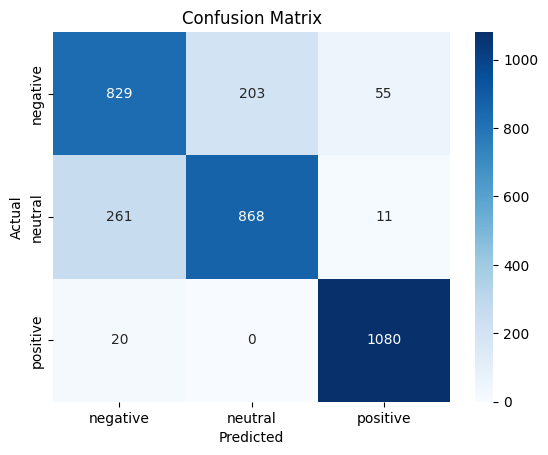

In [504]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive']))

**Third iteration**

In [505]:
# Define X and y
X = df3['tweet'].values
y = df3['sentiment'].values

# Define the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='auto')

# Reshape the input data for oversampling
X = X.reshape(-1, 1)

# Apply oversampling to the training data
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Reshape the input data back to its original shape
X_resampled = X_resampled.reshape(-1)

# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_resampled)
X_seq = tokenizer.texts_to_sequences(X_resampled)
X_pad = pad_sequences(X_seq, maxlen=100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_resampled, test_size=0.2, random_state=42)

# Define the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=100))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert y_train and y_test to categorical labels
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Compute the training accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy:', train_acc)

# Compute the testing accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy:', test_acc)

Epoch 1/10
416/416 [==============================] - 16s 37ms/step - loss: 0.6998 - accuracy: 0.6721 - val_loss: 0.4222 - val_accuracy: 0.8206
Epoch 2/10
416/416 [==============================] - 15s 37ms/step - loss: 0.2994 - accuracy: 0.8810 - val_loss: 0.3825 - val_accuracy: 0.8446
Epoch 3/10
416/416 [==============================] - 15s 36ms/step - loss: 0.1864 - accuracy: 0.9339 - val_loss: 0.3614 - val_accuracy: 0.8656
Epoch 4/10
416/416 [==============================] - 15s 36ms/step - loss: 0.1312 - accuracy: 0.9506 - val_loss: 0.3708 - val_accuracy: 0.8632
Epoch 5/10
416/416 [==============================] - 15s 36ms/step - loss: 0.0902 - accuracy: 0.9667 - val_loss: 0.4020 - val_accuracy: 0.8711
Epoch 6/10
416/416 [==============================] - 16s 37ms/step - loss: 0.0654 - accuracy: 0.9766 - val_loss: 0.4304 - val_accuracy: 0.8656
Epoch 7/10
416/416 [==============================] - 15s 37ms/step - loss: 0.0475 - accuracy: 0.9833 - val_loss: 0.4913 - val_accuracy:

104/104 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

    negative       0.84      0.76      0.80      1087
     neutral       0.81      0.86      0.83      1140
    positive       0.97      1.00      0.98      1100

    accuracy                           0.87      3327
   macro avg       0.87      0.87      0.87      3327
weighted avg       0.87      0.87      0.87      3327



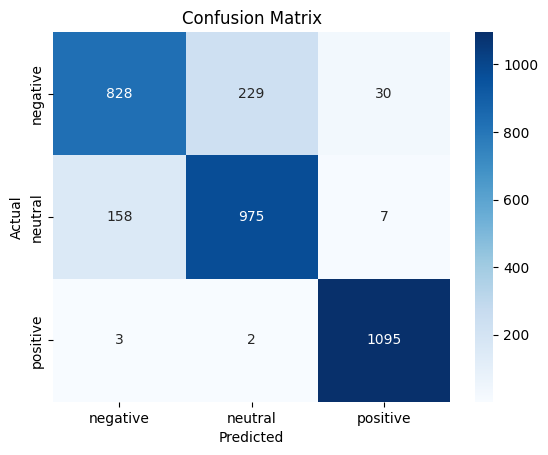

In [507]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive']))

**Fourth iteration**

In [508]:
# Define X and y
X = df3['tweet'].values
y = df3['sentiment'].values

# Define the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='auto')

# Reshape the input data for oversampling
X = X.reshape(-1, 1)

# Apply oversampling to the training data
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Reshape the input data back to its original shape
X_resampled = X_resampled.reshape(-1)

# Tokenize the text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_resampled)
X_seq = tokenizer.texts_to_sequences(X_resampled)
X_pad = pad_sequences(X_seq, maxlen=100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_resampled, test_size=0.2, random_state=42)

# Define the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=100))
model.add(Conv1D(64, 5, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(32, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert y_train and y_test to categorical labels
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Compute the training accuracy
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy:', train_acc)

# Compute the testing accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy:', test_acc)

Epoch 1/10
416/416 [==============================] - 22s 49ms/step - loss: 0.8670 - accuracy: 0.5533 - val_loss: 0.7412 - val_accuracy: 0.6504
Epoch 2/10
416/416 [==============================] - 21s 49ms/step - loss: 0.5073 - accuracy: 0.7723 - val_loss: 0.6099 - val_accuracy: 0.7971
Epoch 3/10
416/416 [==============================] - 20s 49ms/step - loss: 0.3732 - accuracy: 0.8507 - val_loss: 0.5203 - val_accuracy: 0.8133
Epoch 4/10
416/416 [==============================] - 21s 49ms/step - loss: 0.2978 - accuracy: 0.8809 - val_loss: 0.4583 - val_accuracy: 0.8389
Epoch 5/10
416/416 [==============================] - 20s 49ms/step - loss: 0.2595 - accuracy: 0.8994 - val_loss: 0.4349 - val_accuracy: 0.8332
Epoch 6/10
416/416 [==============================] - 20s 48ms/step - loss: 0.2270 - accuracy: 0.9109 - val_loss: 0.4272 - val_accuracy: 0.8311
Epoch 7/10
416/416 [==============================] - 21s 51ms/step - loss: 0.2062 - accuracy: 0.9163 - val_loss: 0.4078 - val_accuracy:

104/104 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

    negative       0.76      0.76      0.76      1087
     neutral       0.82      0.76      0.79      1140
    positive       0.93      1.00      0.96      1100

    accuracy                           0.84      3327
   macro avg       0.84      0.84      0.84      3327
weighted avg       0.84      0.84      0.84      3327



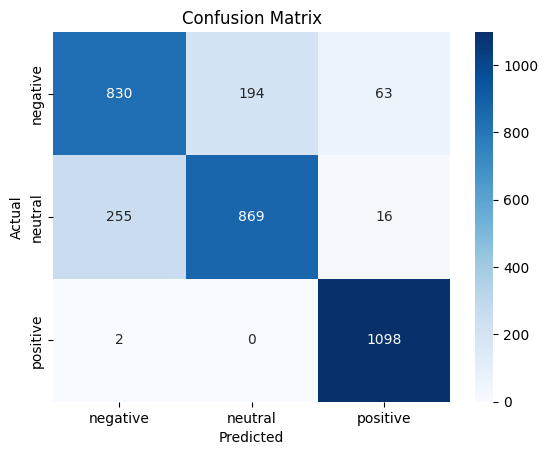

In [509]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Print the classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive']))

## Strengths and Weaknesses

In [512]:
# Get the model's predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

# Print the ROC AUC score
print('ROC AUC Score:', roc_auc)

104/104 [==============================] - 1s 6ms/step
ROC AUC Score: 0.9415408032228155


104/104 [==============================] - 1s 6ms/step


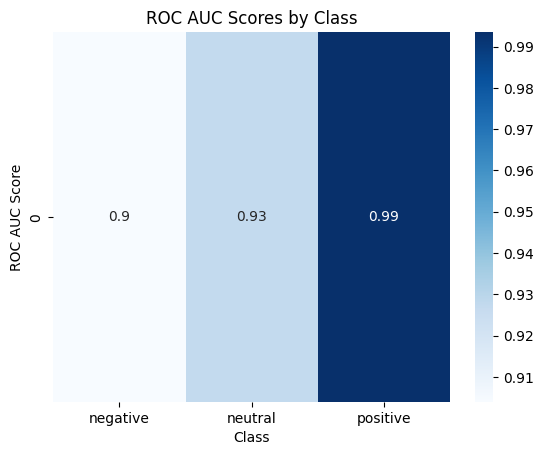

In [513]:
from sklearn.metrics import roc_auc_score

# Get the model's predicted probabilities for each class
y_pred_prob = model.predict(X_test)

# Compute the ROC AUC scores for each class
roc_auc_scores = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average=None)

# Create a heatmap to visualize the scores
sns.heatmap([roc_auc_scores], annot=True, cmap='Blues', xticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Class')
plt.ylabel('ROC AUC Score')
plt.title('ROC AUC Scores by Class')
plt.show()

**Network Graph**

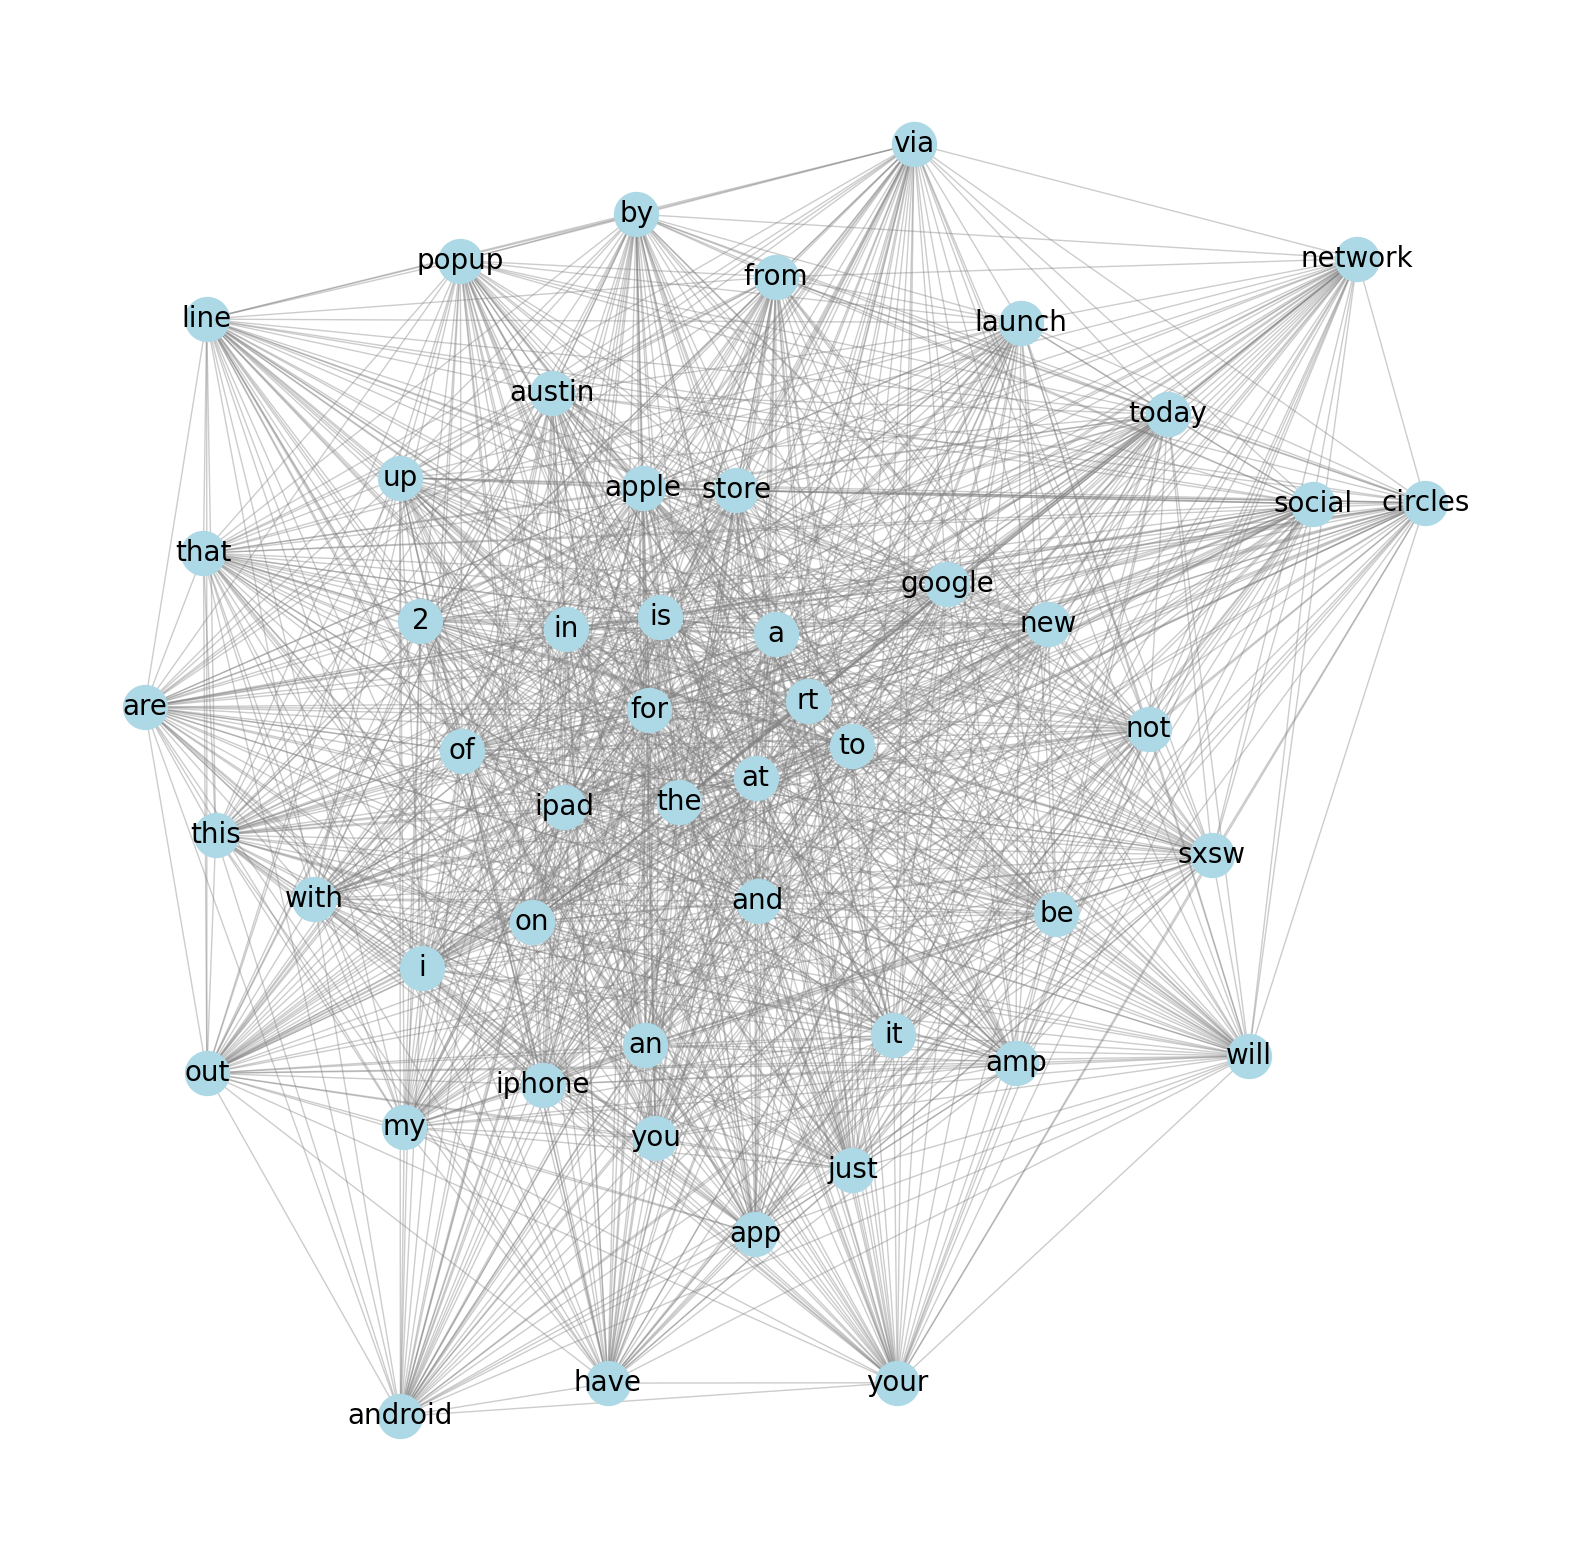

In [514]:
# Create a list of all words in the corpus
all_words = []
for text in df3['tweet']:
    all_words.extend(text.split())

# Create a list of the most frequent words
freq_words = [word for word, count in Counter(all_words).most_common(50)]

# Create a co-occurrence matrix
co_occurrence_matrix = np.zeros((len(freq_words), len(freq_words)))
for text in df3['tweet']:
    words = text.split()
    for i, word1 in enumerate(freq_words):
        if word1 in words:
            for j, word2 in enumerate(freq_words):
                if word2 in words and i != j:
                    co_occurrence_matrix[i][j] += 1

# Create a network graph
G = nx.Graph()
for i, word in enumerate(freq_words):
    G.add_node(word)
    for j, word2 in enumerate(freq_words):
        if co_occurrence_matrix[i][j] > 0:
            G.add_edge(word, word2, weight=co_occurrence_matrix[i][j])

# Visualize the graph
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
plt.axis('off')
plt.show()

**Word Cloud**

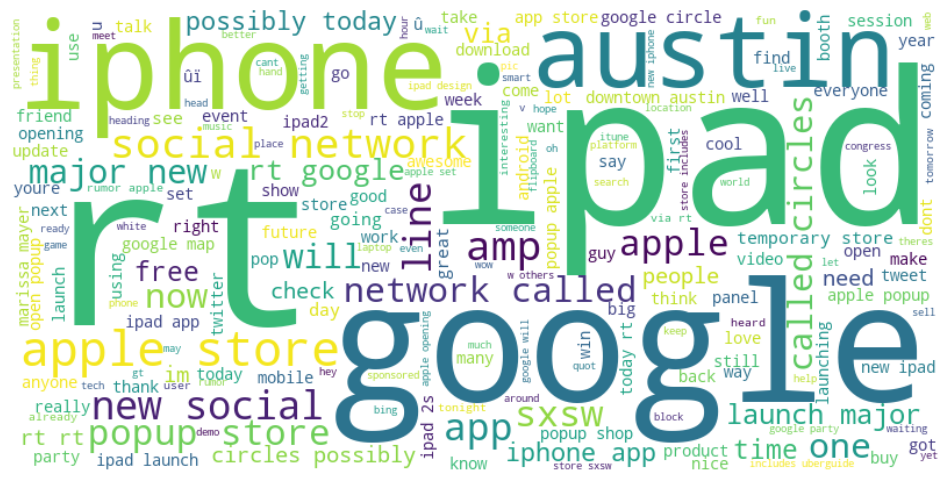

In [515]:
# Join all text data into a single string
text = " ".join(review for review in df3['tweet'])

# Create the wordcloud object
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(text)

# Display the wordcloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Make dataset Binary

In [373]:
sentiment_counts = df3['sentiment'].value_counts()
print(sentiment_counts)

 0    5544
 1    2978
-1     570
Name: sentiment, dtype: int64


In [374]:
df4 = df3.copy()

In [375]:
df4.sentiment.value_counts()

 0    5544
 1    2978
-1     570
Name: sentiment, dtype: int64

In [376]:
df4['neg_notneg_target'] = df4.sentiment.map({-1:-1, 0:1, 1:1})

In [378]:
df4.neg_notneg_target.value_counts()

 1    8522
-1     570
Name: neg_notneg_target, dtype: int64

In [379]:
from imblearn.over_sampling import RandomOverSampler

# define X and y
X = df4['tweet'].values
y = df4['neg_notneg_target'].values

# define the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the oversampling strategy to the training data
X_resampled, y_resampled = oversample.fit_resample(X.reshape(-1, 1), y)

# resetting so misclassification index matches up
df = df.reset_index(drop=True)
df4 = df4.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(df4['tweet'], df4['neg_notneg_target'], test_size=0.2, random_state=42)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled.squeeze(), y_resampled, test_size=0.2, random_state=42)

# define the pipeline steps
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('clf', MultinomialNB())
])

# define the hyperparameters to search over
param_grid = {
    'vectorizer__max_features': [1000, 5000, 10000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.1, 1, 10]
}

# perform a grid search over the hyperparameters
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

# make predictions on the test data
y_pred = grid.predict(X_test)

# evaluate the accuracy of the model
accuracy = grid.score(X_test, y_test)
print(" Test Accuracy:", accuracy)

# evaluate the accuracy of the training model
train_accuracy = grid.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)

 Test Accuracy: 0.9524787327662071
Train Accuracy: 0.966996699669967


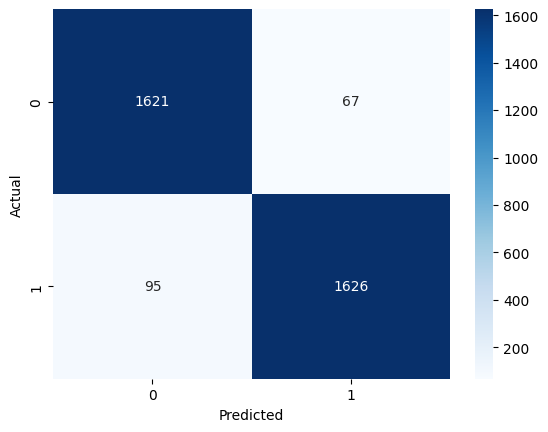

,precision,recall,f1-score,support
-1,0.944639,0.960308,0.952409,1688.000000
1,0.960425,0.944800,0.952548,1721.000000
accuracy,0.952479,0.952479,0.952479,0.952479
macro avg,0.952532,0.952554,0.952479,3409.000000
weighted avg,0.952608,0.952479,0.952479,3409.000000


In [380]:
# generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# extract the individual scores for each class and store them in a DataFrame
scores_df = pd.DataFrame(report).transpose()

# print the report
scores_df

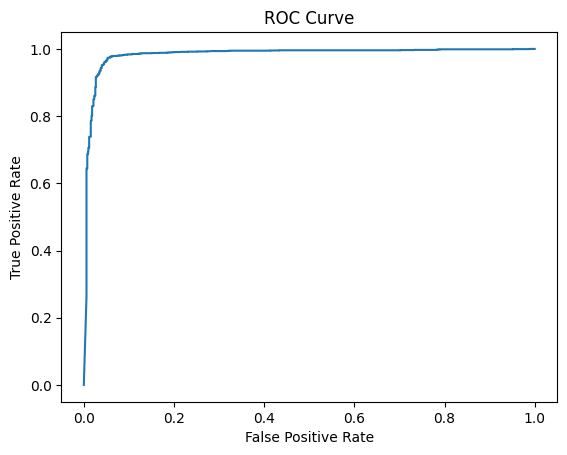

AUC: 0.9833828907474162


In [381]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for test set
y_prob = grid.predict_proba(X_test)[:, 1]

# Compute FPR and TPR for different probability thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Compute AUC
auc = roc_auc_score(y_test, y_prob)
print('AUC:', auc)

# Misclassifications

In [384]:
mask = y_pred != y_test
misclassified_texts = X_test[mask]
true_labels = y_test[mask]
predicted_labels = y_pred[mask]

# Get the original indices from X_test before the train-test split
original_indices = pd.DataFrame(X_test).reset_index(drop=True).index[mask]

df_misclassified = pd.DataFrame({'text': misclassified_texts, 'true_label': true_labels, 'predicted_label': predicted_labels, 'original_index': original_indices})
print(df_misclassified)

                                                  text  true_label  \
0    my kingdom for a way to filter tweets that inc...           1   
1    rt ipad store sold out of everything except 64...          -1   
2    room is full here at re ipad design headaches ...           1   
3    so is going to try again with to be announced ...           1   
4    cant wait to see the internet implode in austi...           1   
..                                                 ...         ...   
157           queue at apple popup store at still long          -1   
158  enough already ûï google to launch major new s...          -1   
159   day 1 as expected everyone is glued to their ...           1   
160  how could i forget my cell phone today for wha...           1   
161  rt ipad store sold out of everything except 64...          -1   

     predicted_label  original_index  
0                 -1               1  
1                  1             100  
2                 -1             103  
3  

In [385]:
df_misclassified

,text,true_label,predicted_label,original_index
0,my kingdom for a way to filter tweets that inc...,1,-1,1
1,rt ipad store sold out of everything except 64...,-1,1,100
2,room is full here at re ipad design headaches ...,1,-1,103
3,so is going to try again with to be announced ...,1,-1,124
4,cant wait to see the internet implode in austi...,1,-1,166
...,...,...,...,...
157,queue at apple popup store at still long,-1,1,3288
158,enough already ûï google to launch major new s...,-1,1,3313
159,day 1 as expected everyone is glued to their ...,1,-1,3321
160,how could i forget my cell phone today for wha...,1,-1,3323


In [387]:
print(df_misclassified.iloc[]['text'])

queue at apple popup store at still long


# Evaluation

My **fourth iteration model** produced the best results predicting multiclass sentiment. It was most accurate on the test without overfitting.